# **Inital Capstone Data Upload and EDA**

### **Author:** Mark Shumka

### **Contact:** markshumka@gmail.com

### **Date:** October 20, 2023

## **Table of Contents** ##

## **Introduction** ##

In this notebook, I will upload and begin to explore the datasets. I have sourced two datasets to provide the information that I want, and I plan to merge them into a single one for analysis. The first dataset comes from [Moneypuck.com](moneypuck.com). It contains Advanced Stats for all NHL games from the 2008-09 season to the 2022-23 season, aggregated at a team level. The second dataset contains the basic statistics for each game published by the NHL itself (although downloaded from Kaggle). I am tempted to exclude the second dataset, as the first dataset contains almost all of the same columns of data, albeit with different names. The second dataset does have a column that states whether the team won or lost, which is the dependent variable I will be attempting to predict. I could conceivably subtract 'goals against' from 'goals for' in the first dataset, and create a binary variable for win or loss based on whether that calculation was positive or negative, but I would feel more comfortable with the official win/loss result data. In addition, it appears that only the second dataset includes powerplay opportunities and goals, i.e., goals scored when the other team has taken a penalty and is playing shorthanded. I suspect that these goals will be correlated with wins, so I want to include it. As a result, I will go ahead and merge the two datasets into one. How hard could it be??

*(Spoiler alert: it was VERY hard. However, as I was going through it, I did a quick experiment to understand whether I could exclude the second dataset altogether. The first dataset is player data aggregated at the team level, but there are situations where a team can win a game when no individual player scores the winning goal. Specifically, if a regular season game is tied at the end of regulation time and overtime, it is decided in a shootout. The team that wins is credited with a goal that puts them ahead of the other team, but no individual player is credited with a goal. Based on that, I hypothesized that subtracting 'goals against' from 'goals for' in the first dataset would sometimes give a result of 0, which would not allow me to determine the game winner from that dataset alone. Sure enough, there are multiple instances where the difference between 'goals for' and 'goals against' in that dataset is 0. Consider this bonus EDA that doesn't appear later in this doc, but is extremely important in ensuring that the final merged dataset has the information I need!)*

Before we begin, let's set up our standard modules.

In [949]:
# Import standard data science & visualization packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's go ahead and upload the first dataset of Advanced Stats.

In [950]:
# load the dataset
mp_df = pd.read_csv('all_teams.csv')

In [951]:
# See the shape
mp_df.shape

(190300, 111)

In [952]:
# .info won't show the individual column details unless we include the number of columns to show. There are 111 columns in this dataset.
mp_df.info(111)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190300 entries, 0 to 190299
Data columns (total 111 columns):
 #    Column                                     Dtype  
---   ------                                     -----  
 0    team                                       object 
 1    season                                     int64  
 2    name                                       object 
 3    gameId                                     int64  
 4    playerTeam                                 object 
 5    opposingTeam                               object 
 6    home_or_away                               object 
 7    gameDate                                   int64  
 8    position                                   object 
 9    situation                                  object 
 10   xGoalsPercentage                           float64
 11   corsiPercentage                            float64
 12   fenwickPercentage                          float64
 13   iceTime                    

The data is mostly numeric, but there are a number of non-numeric columns upfront. We will hold off on doing anything with these until we see what the other dataset looks like.

In [953]:
mp_df.head()

,team,season,name,gameId,playerTeam,opposingTeam,home_or_away,gameDate,position,situation,...,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoffGame
0,NYR,2008,NYR,2008020001,NYR,T.B,AWAY,20081004,Team Level,other,...,1.0,1.000,0.0,0.017,0.000,0.000,0.037,0.037,0.037,0
1,NYR,2008,NYR,2008020001,NYR,T.B,AWAY,20081004,Team Level,all,...,31.0,30.369,5.0,0.396,0.168,0.168,2.917,2.833,2.714,0
2,NYR,2008,NYR,2008020001,NYR,T.B,AWAY,20081004,Team Level,5on5,...,20.0,19.369,3.0,0.237,0.168,0.168,1.862,1.777,1.665,0
3,NYR,2008,NYR,2008020001,NYR,T.B,AWAY,20081004,Team Level,4on5,...,9.0,9.000,1.0,0.124,0.000,0.000,0.795,0.795,0.789,0
4,NYR,2008,NYR,2008020001,NYR,T.B,AWAY,20081004,Team Level,5on4,...,1.0,1.000,1.0,0.019,0.000,0.000,0.224,0.224,0.224,0


Each row in the dataframe represents team statistics for a specific game. We can see that there are columns indicating the team, as well as the opposing team they faced in that game. There is also a unique gameID column that follows a standard format to identify each game separately. Each gameID has two separate sets of rows, one set for each team. However, there are multiple rows for each team/game combination. This is because there are rows for different game situations (listed in the 'situation' column), specifically around when one team or the other has a penalty, leaving them shorthanded. In fact, there are 5 rows for each team/game combination. For the purposes of predicting future game outcomes, we will only need the total statistics for each game, as it would be difficult to accurately predict the penalties that a team takes in a given match. As a result, we can filter the dataframe down to only include rows where the value in the situation column is "all".

In [954]:
# Filter mp_df to select only rows where 'situation' is equal to 'all'
filtered_mp_df = mp_df[mp_df['situation'] == 'all']

In [955]:
# Check to ensure that the new dataframe only contains rows where `situation` = 'all'
filtered_mp_df.head()

,team,season,name,gameId,playerTeam,opposingTeam,home_or_away,gameDate,position,situation,...,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoffGame
1,NYR,2008,NYR,2008020001,NYR,T.B,AWAY,20081004,Team Level,all,...,31.0,30.369,5.0,0.396,0.168,0.168,2.917,2.833,2.714,0
6,NYR,2008,NYR,2008020003,NYR,T.B,HOME,20081005,Team Level,all,...,32.0,31.984,5.0,0.241,0.000,0.000,1.091,1.117,1.091,0
11,NYR,2008,NYR,2008020010,NYR,CHI,HOME,20081010,Team Level,all,...,45.0,43.911,3.0,0.448,0.407,0.407,2.738,2.751,2.730,0
16,NYR,2008,NYR,2008020019,NYR,PHI,AWAY,20081011,Team Level,all,...,41.0,38.025,4.0,0.504,0.401,0.401,3.123,2.958,2.907,0
21,NYR,2008,NYR,2008020034,NYR,N.J,HOME,20081013,Team Level,all,...,39.0,38.019,3.0,0.383,1.139,1.139,2.698,2.691,2.242,0


In [956]:
# Let's reset the index for now. We can drop it later if necessary.
filtered_mp_df.reset_index()

,index,team,season,name,gameId,playerTeam,opposingTeam,home_or_away,gameDate,position,...,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoffGame
0,1,NYR,2008,NYR,2008020001,NYR,T.B,AWAY,20081004,Team Level,...,31.0,30.369,5.0,0.396,0.168,0.168,2.917,2.833,2.714,0
1,6,NYR,2008,NYR,2008020003,NYR,T.B,HOME,20081005,Team Level,...,32.0,31.984,5.0,0.241,0.000,0.000,1.091,1.117,1.091,0
2,11,NYR,2008,NYR,2008020010,NYR,CHI,HOME,20081010,Team Level,...,45.0,43.911,3.0,0.448,0.407,0.407,2.738,2.751,2.730,0
3,16,NYR,2008,NYR,2008020019,NYR,PHI,AWAY,20081011,Team Level,...,41.0,38.025,4.0,0.504,0.401,0.401,3.123,2.958,2.907,0
4,21,NYR,2008,NYR,2008020034,NYR,N.J,HOME,20081013,Team Level,...,39.0,38.019,3.0,0.383,1.139,1.139,2.698,2.691,2.242,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38055,190276,L.A,2015,L.A,2015030185,L.A,S.J,HOME,20160422,Team Level,...,36.0,39.463,10.0,0.370,0.261,0.261,2.152,2.314,2.307,1
38056,190281,L.A,2017,L.A,2017030171,L.A,VGK,AWAY,20180411,Team Level,...,51.0,52.184,4.0,0.509,0.000,0.000,2.788,2.783,2.733,1
38057,190286,L.A,2017,L.A,2017030172,L.A,VGK,AWAY,20180413,Team Level,...,76.0,75.118,3.0,0.788,0.962,0.962,4.469,4.347,4.234,1
38058,190291,L.A,2017,L.A,2017030173,L.A,VGK,HOME,20180415,Team Level,...,46.0,46.316,6.0,0.506,0.613,0.613,3.051,3.139,3.107,1


In [957]:
# What does the new dataframe look like?
filtered_mp_df.shape

(38060, 111)

In [958]:
print(f'There are {filtered_mp_df.shape[0]} columns and {filtered_mp_df.shape[1]} rows')

There are 38060 columns and 111 rows


Is this the actual number of games played over these seasons? Before I go and find the number of games per season (which has changed for multiple reasons, including strikes, lockouts, and COVID-19) and multiply by the number of teams (which has increased due to the addition of Las Vegas in 2016 and Seattle in 2019), I would like to take a look at the number of games per season in the dataset, to ensure that it's consistent when expected. 

In [959]:
# Count the number of values per season
filtered_mp_df['season'].value_counts()

2021    2802
2022    2800
2018    2716
2017    2710
2013    2646
2015    2642
2014    2638
2009    2636
2010    2636
2016    2634
2011    2632
2008    2628
2019    2424
2020    1904
2012    1612
Name: season, dtype: int64

Oops, it's not consistent. For the majority of the time this dataset comprises, there were 30 teams, each playing 82 games. This works out to 2,460 games, which would be the amount we would expect to see for each season. There's only one possible explanation for the higher number - PLAYOFFS. And revisiting the dataframe info, we see that all the way at the end, the last column is called 'playoffGame', with a value of '1' when it is a playoff game. So this explains the inconsistency in yearly game totals, as the playoffs consist of four rounds of best-of-7 series, which means that the number of games varies depending on results. 

Should we include playoff games in our analysis? It is a commonly-held belief that the regular season is not an accurate predictor of playoff outcome, as the style of game and the officiating change in the playoffs. We will determine whether or not to include the playoffs before beginning our full analysis and modeling (unless there is time to do a separate analysis of the comparability of the regular season and the playoffs).

In [960]:
# Check for null values
filtered_mp_df.isna().sum()

team                                         0
season                                       0
name                                         0
gameId                                       0
playerTeam                                   0
                                            ..
reboundxGoalsAgainst                         0
totalShotCreditAgainst                       0
scoreAdjustedTotalShotCreditAgainst          0
scoreFlurryAdjustedTotalShotCreditAgainst    0
playoffGame                                  0
Length: 111, dtype: int64

In [961]:
# Since that list is long, let's check for null values in each column
columns_with_null = filtered_mp_df.columns[filtered_mp_df.isna().any()]

# Display columns with null values, if any
if not columns_with_null.empty:
    print("Columns with null values:")
    print(columns_with_null)
else:
    print("No columns have null values.")

No columns have null values.


In [962]:
# Check for duplicated rows
filtered_mp_df.duplicated().sum()

0

In [963]:
# Check for duplicated columns
filtered_mp_df.T.duplicated()

team                                         False
season                                       False
name                                          True
gameId                                       False
playerTeam                                    True
                                             ...  
reboundxGoalsAgainst                         False
totalShotCreditAgainst                       False
scoreAdjustedTotalShotCreditAgainst          False
scoreFlurryAdjustedTotalShotCreditAgainst    False
playoffGame                                  False
Length: 111, dtype: bool

In [964]:
# Sort the results to see if there are more than two duplicate
duplicated_rows = filtered_mp_df.T.duplicated()
duplicated_rows.sort_values(ascending=False)

name                                      True
playerTeam                                True
team                                     False
flurryScoreVenueAdjustedxGoalsAgainst    False
playContinuedOutsideZoneAgainst          False
                                         ...  
savedShotsOnGoalFor                      False
playContinuedOutsideZoneFor              False
playContinuedInZoneFor                   False
playStoppedFor                           False
playoffGame                              False
Length: 111, dtype: bool

In [965]:
# Alternatively, we could do the sum of the duplicated result to confirm how many duplicate columns there are
filtered_mp_df.T.duplicated().sum()

2

In [966]:
# Look at the duplicated columns
filtered_mp_df[['team', 'name', 'playerTeam']]

,team,name,playerTeam
1,NYR,NYR,NYR
6,NYR,NYR,NYR
11,NYR,NYR,NYR
16,NYR,NYR,NYR
21,NYR,NYR,NYR
...,...,...,...
190276,L.A,L.A,L.A
190281,L.A,L.A,L.A
190286,L.A,L.A,L.A
190291,L.A,L.A,L.A


Okay, there are three columns that all contain the same information. We can drop two of them. Let's drop `name` and `playerTeam`.

In [967]:
filtered_mp_df = filtered_mp_df.drop(columns=['name', 'playerTeam'])

In [968]:
filtered_mp_df.shape

(38060, 109)

That was a pretty clean dataset. Now we can import our second dataset and examine it before merging them together. It contains the basic statistics for each game published by the NHL itself (although downloaded from Kaggle).

In [969]:
gts_df = pd.read_csv('game_teams_stats.csv')

In [970]:
gts_df.shape

(52610, 17)

We saw that the dataset above contained games beginning in the 2008-09 season. Before we explore this second dataset further. Let's confirm how far back the data goes.

In [971]:
gts_df.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide
0,2016020045,4,away,False,REG,Dave Hakstol,4.0,27.0,30.0,6.0,4.0,2.0,50.9,12.0,9.0,11.0,left
1,2016020045,16,home,True,REG,Joel Quenneville,7.0,28.0,20.0,8.0,3.0,2.0,49.1,16.0,8.0,9.0,left
2,2017020812,24,away,True,OT,Randy Carlyle,4.0,34.0,16.0,6.0,3.0,1.0,43.8,7.0,4.0,14.0,right
3,2017020812,7,home,False,OT,Phil Housley,3.0,33.0,17.0,8.0,2.0,1.0,56.2,5.0,6.0,14.0,right
4,2015020314,21,away,True,REG,Patrick Roy,4.0,29.0,17.0,9.0,3.0,1.0,45.7,13.0,5.0,20.0,left


There is no season or year column in this data to indicate when the games took place, but there is a game_id column, which we learned above includes the season information in the first four digits. Sorting by that column will show us when the data started.

In [972]:
gts_df.sort_values(by='game_id', ascending=True)

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide
36857,2000020001,21,away,False,OT,Bob Hartley,2.0,28.0,NaN,20.0,10.0,1.0,NaN,NaN,NaN,NaN,left
36858,2000020001,25,home,False,OT,Ken Hitchcock,2.0,21.0,NaN,22.0,9.0,1.0,NaN,NaN,NaN,NaN,left
38303,2000020002,9,away,False,OT,Jacques Martin,4.0,33.0,NaN,20.0,6.0,2.0,NaN,NaN,NaN,NaN,right
38304,2000020002,6,home,False,OT,Pat Burns,4.0,38.0,NaN,12.0,10.0,2.0,NaN,NaN,NaN,NaN,right
36159,2000020003,7,home,True,REG,Lindy Ruff,4.0,30.0,NaN,21.0,3.0,0.0,NaN,NaN,NaN,NaN,right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45396,2019040652,90,away,True,tbc,Rick Tocchet,10.0,28.0,0.0,0.0,0.0,0.0,35.0,1.0,6.0,1.0,NaN
45399,2019040653,90,home,True,tbc,Rick Tocchet,5.0,20.0,0.0,0.0,0.0,0.0,62.5,1.0,6.0,2.0,NaN
45398,2019040653,87,away,False,tbc,Bruce Cassidy,4.0,11.0,0.0,0.0,0.0,0.0,37.5,2.0,5.0,2.0,NaN
45392,2019040653,87,away,False,tbc,Bruce Cassidy,4.0,11.0,0.0,0.0,0.0,0.0,37.5,2.0,5.0,2.0,NaN


This peek into the data gives us a few insights. First, the dataset begins in 2000, so we can filter out the first eight seasons of data before merging with the other dataset. Second, it has a lot of null values in the initial rows. Perhaps by excluding these seasons, we will avoid the null values issue. Third, the data only extends through the 2019-20 season. It would be nice to have more current data than that, so I will continue to look for sources for that, but in the meantime, we may limit both datasets to 2008-2020. Finally, there are weird values in the 'settled_in' column in the final rows. We will explore that prior to merging the data.  For now, we can start by filtering out the first eight seasons.

In [973]:
# Filter out games pre-2008
filtered_gts_df = gts_df[gts_df['game_id'] >= 2008000000]

In [974]:
# What does the new dataframe look like?
filtered_gts_df.shape

(35390, 17)

In [975]:
print(f'There are {filtered_gts_df.shape[0]} columns and {filtered_gts_df.shape[1]} rows')

There are 35390 columns and 17 rows


There are fewer rows in this dataframe than the mp_df one above, but that is to be expected since it contains fewer seasons of data.

In [976]:
filtered_gts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35390 entries, 0 to 52609
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   game_id                 35390 non-null  int64  
 1   team_id                 35390 non-null  int64  
 2   HoA                     35390 non-null  object 
 3   won                     35390 non-null  bool   
 4   settled_in              35390 non-null  object 
 5   head_coach              35362 non-null  object 
 6   goals                   35382 non-null  float64
 7   shots                   35382 non-null  float64
 8   hits                    35382 non-null  float64
 9   pim                     35382 non-null  float64
 10  powerPlayOpportunities  35382 non-null  float64
 11  powerPlayGoals          35382 non-null  float64
 12  faceOffWinPercentage    30462 non-null  float64
 13  giveaways               35382 non-null  float64
 14  takeaways               35382 non-null

Like the above dataset, this one contains mostly numeric data, but a few columns that are non-numeric. It also contains boolean data in the 'won' column, which is where the game winner is indicated. This will be our target variable, so we will likely change it from True/False to 1/0. 

In addition, it looks like there are some null values. Let's take a closer look.

In [978]:
# Check for null values
filtered_gts_df.isna().sum()

game_id                      0
team_id                      0
HoA                          0
won                          0
settled_in                   0
head_coach                  28
goals                        8
shots                        8
hits                         8
pim                          8
powerPlayOpportunities       8
powerPlayGoals               8
faceOffWinPercentage      4928
giveaways                    8
takeaways                    8
blocked                      8
startRinkSide             1244
dtype: int64

Hmm, those columns with 8 null values look suspicious. Let's look at one of them.

In [979]:
filtered_gts_df[filtered_gts_df['goals'].isna()]

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide
40904,2017030185,28,away,False,tbc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40905,2017030185,24,home,False,tbc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40998,2017030326,52,away,False,tbc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40999,2017030326,54,home,False,tbc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41000,2017030327,54,away,False,tbc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41001,2017030327,52,home,False,tbc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41770,2016030217,3,away,False,tbc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41771,2016030217,9,home,False,tbc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Interesting. Those are legitimate game_ids, at least in terms of format. Let's look for one of them in the mp_df dataset.

In [980]:
filtered_mp_df[(filtered_mp_df['gameId'] == 2017030185)]

,team,season,gameId,opposingTeam,home_or_away,gameDate,position,situation,xGoalsPercentage,corsiPercentage,...,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoffGame


No result. After some research, I found this information on the format of game ids:

Game IDs

- will look like this: 2023020001
- The first 4 digits identify the season of the game (ie. 2017 for the 2017-2018 season). Always refer to a season with the starting year. A game played in March 2018 would still have a game ID that starts with 2017
- The next 2 digits give the type of game, where 01 = preseason, 02 = regular season, 03 = playoffs, 04 = all-star
- The final 4 digits identify the specific game number. For regular season and preseason games, this ranges from 0001 to the number of games played. (1353 for seasons with 32 teams (2022 - Present), 1271 for seasons with 31 teams (2017 - 2020) and 1230 for seasons with 30 teams). For playoff games, the 2nd digit of the specific number gives the round of the playoffs, the 3rd digit specifies the matchup, and the 4th digit specifies the game (out of 7).

Based on that information, all of those games were playoff games, each of which would only be played if a team had not yet won 4 games (since the last digit is 5-7). A quick search of the three playoff series represented (the 52 vs. 54 matchup was two games in the same series), shows that San Jose (team 28) defeated Anaheim (team 24) in 4 games, negating the need for a fifth game; Vegas (team 54) defeated Winnipeg (team 52) in 5 games, negating the need for a sixth or seventh game; and Ottawa (team 9) defeated New York (team 3) in 6 games, negating the need for a seventh game. These games appear to have been officially scheduled, but did not take place. Let's remove those rows.

In [981]:
rows_to_remove = [40904, 40905, 40998, 40999, 41000, 41001, 41770, 41771]  

filtered_gts_df = filtered_gts_df.drop(rows_to_remove)

In [982]:
# Check for null values again
filtered_gts_df.isna().sum()

game_id                      0
team_id                      0
HoA                          0
won                          0
settled_in                   0
head_coach                  20
goals                        0
shots                        0
hits                         0
pim                          0
powerPlayOpportunities       0
powerPlayGoals               0
faceOffWinPercentage      4920
giveaways                    0
takeaways                    0
blocked                      0
startRinkSide             1236
dtype: int64

Okay, they're gone. We will leave the remaining rows with null values for now, and decide what to do with them once we have merged the datasets.

In [983]:
# Check for duplicated rows
filtered_gts_df.duplicated().sum()

5140

Interesting, there are a bunch of duplicated rows. Let's see if we can figure out what's going on. We'll start by taking a look at the value counts of the game_id column. As a reminder, we would expect a value of 2 for each game_id, as each game has two rows, one for each team.

In [984]:
filtered_gts_df['game_id'].value_counts()

2018030417    4
2019020800    4
2019020859    4
2019020858    4
2019020857    4
             ..
2012020439    2
2013021128    2
2012020681    2
2013021079    2
2011020032    2
Name: game_id, Length: 15121, dtype: int64

In [985]:
# How many game_ids have 4 rows?
game_id_counts = filtered_gts_df['game_id'].value_counts()
game_ids_with_count_4 = game_id_counts[game_id_counts == 4].index

count_of_game_ids_with_4 = len(game_ids_with_count_4)
count_of_game_ids_with_4

2570

2,570 is half of the 5,140 duplicate rows, which would make sense, since duplicating both of the game_id rows for those game_ids would lead to 5,140 duplicate rows. Let's take a quick look at one of the game_ids.

In [986]:
filtered_gts_df[(filtered_gts_df['game_id'] == 2018030417)]

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide
52606,2018030417,19,away,True,REG,Craig Berube,4.0,20.0,36.0,2.0,0.0,0.0,49.0,7.0,8.0,21.0,right
52607,2018030417,6,home,False,REG,Bruce Cassidy,1.0,33.0,28.0,0.0,1.0,0.0,51.0,13.0,6.0,7.0,right
52608,2018030417,19,away,True,REG,Craig Berube,4.0,20.0,36.0,2.0,0.0,0.0,49.0,7.0,8.0,21.0,right
52609,2018030417,6,home,False,REG,Bruce Cassidy,1.0,33.0,28.0,0.0,1.0,0.0,51.0,13.0,6.0,7.0,right


This confirms that for some reason, possibly human error when compiling the dataset, values for these game ids were included twice. We can go ahead and drop the duplicates.

In [987]:
# drop duplicate rows
filtered_gts_df = filtered_gts_df.drop_duplicates()

In [988]:
# Check for duplicated rows again
filtered_gts_df.duplicated().sum()

0

In [989]:
# Check for duplicated columns
filtered_gts_df.T.duplicated()

game_id                   False
team_id                   False
HoA                       False
won                       False
settled_in                False
head_coach                False
goals                     False
shots                     False
hits                      False
pim                       False
powerPlayOpportunities    False
powerPlayGoals            False
faceOffWinPercentage      False
giveaways                 False
takeaways                 False
blocked                   False
startRinkSide             False
dtype: bool

Looks good. Before we merge the datasets, let's take another look at this data to figure out how we're going to merge.

In [990]:
filtered_gts_df.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide
0,2016020045,4,away,False,REG,Dave Hakstol,4.0,27.0,30.0,6.0,4.0,2.0,50.9,12.0,9.0,11.0,left
1,2016020045,16,home,True,REG,Joel Quenneville,7.0,28.0,20.0,8.0,3.0,2.0,49.1,16.0,8.0,9.0,left
2,2017020812,24,away,True,OT,Randy Carlyle,4.0,34.0,16.0,6.0,3.0,1.0,43.8,7.0,4.0,14.0,right
3,2017020812,7,home,False,OT,Phil Housley,3.0,33.0,17.0,8.0,2.0,1.0,56.2,5.0,6.0,14.0,right
4,2015020314,21,away,True,REG,Patrick Roy,4.0,29.0,17.0,9.0,3.0,1.0,45.7,13.0,5.0,20.0,left


We can see that this dataset has a game_id column, which corresponds to the gameId column in the first dataset. Let's confirm that the data matches between the two datasets by retrieving the rows in the first dataset that have the same game ID as the first two rows in this dataset.

In [912]:
filtered_mp_df[(filtered_mp_df['gameId'] == 2016020045)]

,team,season,gameId,opposingTeam,home_or_away,gameDate,position,situation,xGoalsPercentage,corsiPercentage,...,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoffGame
27836,PHI,2016,2016020045,CHI,AWAY,20161018,Team Level,all,0.4809,0.5057,...,32.0,32.941,16.0,0.349,0.166,0.166,3.413,3.432,3.422,0
137241,CHI,2016,2016020045,PHI,HOME,20161018,Team Level,all,0.5191,0.4943,...,35.0,34.084,12.0,0.396,1.980,1.980,1.410,1.400,1.388,0


Unfortunately, we cannot compare directly between the two results because we do not have another common unique identifier that would confirm. They both share a value of "home" or "away", but all games have those dual values, so that doesn't help. We happen to know that Dave Hakstol coached Philadelphia and Joel Quenneville coached Chicago in the 2016-17 season, so are confident that these rows match, but that's not a practical method for analyzing all rows or for merging data. We would ideally confirm by comparing the team names, but the gts_df dataset includes a team ID instead of a name. Fortunately, the source of the data provided an additional file with team information, which we can call to compare.

In [991]:
team_info = pd.read_csv('team_info.csv')
team_info.sort_values(by='team_id', ascending=True)

,team_id,franchiseId,shortName,teamName,abbreviation,link
0,1,23,New Jersey,Devils,NJD,/api/v1/teams/1
19,2,22,NY Islanders,Islanders,NYI,/api/v1/teams/2
5,3,10,NY Rangers,Rangers,NYR,/api/v1/teams/3
1,4,16,Philadelphia,Flyers,PHI,/api/v1/teams/4
6,5,17,Pittsburgh,Penguins,PIT,/api/v1/teams/5
4,6,6,Boston,Bruins,BOS,/api/v1/teams/6
22,7,19,Buffalo,Sabres,BUF,/api/v1/teams/7
13,8,1,Montreal,Canadiens,MTL,/api/v1/teams/8
12,9,30,Ottawa,Senators,OTT,/api/v1/teams/9
20,10,5,Toronto,Maple Leafs,TOR,/api/v1/teams/10


We can see that the abbreviation for team_id 4 is PHI (Philadelphia), and the abbreviation for team_id 16 is CHI (Chicago). These correspond to the team abbreviations in our initial dataset, and in both cases PHI is 'away' and CHI is 'home'. So we have confirmed that gameId key is the same for both datasets. Using this information, we should be good to merge the dataframes into a single dataframe. To merge the files, let's first add the team abbreviation to the gts_df dataset.

In [992]:
# Create a mapping between 'team_id' and 'abbreviation' from the 'team_info' dataframe
team_id_to_abbreviation = team_info[['team_id', 'abbreviation']]

# Merge the 'team_id' mapping with 'filtered_gts_df' based on the 'team_id' column
filtered_gts_df = filtered_gts_df.merge(team_id_to_abbreviation, on='team_id', how='left')

# Rename the 'abbreviation' column to 'team'
filtered_gts_df.rename(columns={'abbreviation': 'team'}, inplace=True)

In [993]:
filtered_gts_df

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide,team
0,2016020045,4,away,False,REG,Dave Hakstol,4.0,27.0,30.0,6.0,4.0,2.0,50.9,12.0,9.0,11.0,left,PHI
1,2016020045,16,home,True,REG,Joel Quenneville,7.0,28.0,20.0,8.0,3.0,2.0,49.1,16.0,8.0,9.0,left,CHI
2,2017020812,24,away,True,OT,Randy Carlyle,4.0,34.0,16.0,6.0,3.0,1.0,43.8,7.0,4.0,14.0,right,ANA
3,2017020812,7,home,False,OT,Phil Housley,3.0,33.0,17.0,8.0,2.0,1.0,56.2,5.0,6.0,14.0,right,BUF
4,2015020314,21,away,True,REG,Patrick Roy,4.0,29.0,17.0,9.0,3.0,1.0,45.7,13.0,5.0,20.0,left,COL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30237,2018030415,6,home,False,REG,Bruce Cassidy,1.0,39.0,43.0,2.0,3.0,0.0,40.6,4.0,11.0,15.0,right,BOS
30238,2018030416,6,away,True,REG,Bruce Cassidy,5.0,32.0,27.0,10.0,4.0,1.0,41.3,4.0,10.0,16.0,right,BOS
30239,2018030416,19,home,False,REG,Craig Berube,1.0,29.0,29.0,20.0,4.0,0.0,58.7,12.0,11.0,9.0,right,STL
30240,2018030417,19,away,True,REG,Craig Berube,4.0,20.0,36.0,2.0,0.0,0.0,49.0,7.0,8.0,21.0,right,STL


Okay, we should be good to merge the two dataframes.

In [1013]:
# Convert 'gameId' to a string in both DataFrames
filtered_mp_df['gameId'] = filtered_mp_df['gameId'].astype(str)
filtered_gts_df['game_id'] = filtered_gts_df['game_id'].astype(str)

# Create a new column with a combination of 'gameId' and 'team' in both dataframes
filtered_mp_df['merge_key'] = filtered_mp_df['gameId'] + '_' + filtered_mp_df['team']
filtered_gts_df['merge_key'] = filtered_gts_df['game_id'] + '_' + filtered_gts_df['team']

# Merge dataframes based on the new 'merge_key' column
merged_df = filtered_mp_df.merge(filtered_gts_df, on='merge_key', how='left')

# Drop the 'merge_key'
merged_df.drop(columns=['merge_key'], inplace=True)

In [1014]:
merged_df.shape

(38060, 127)

In [1015]:
print(f'There are {merged_df.shape[0]} columns and {merged_df.shape[1]} rows')

There are 38060 columns and 127 rows


In [1016]:
merged_df.head()

,team_x,season,gameId,opposingTeam,home_or_away,gameDate,position,situation,xGoalsPercentage,corsiPercentage,...,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide,team_y
0,NYR,2008,2008020001,TBL,AWAY,20081004,Team Level,all,0.4596,0.6408,...,16.0,8.0,7.0,1.0,NaN,8.0,19.0,6.0,right,NYR
1,NYR,2008,2008020003,TBL,HOME,20081005,Team Level,all,0.6619,0.6207,...,10.0,15.0,4.0,1.0,NaN,11.0,12.0,12.0,left,NYR
2,NYR,2008,2008020010,CHI,HOME,20081010,Team Level,all,0.4123,0.4904,...,44.0,16.0,3.0,0.0,NaN,6.0,7.0,8.0,left,NYR
3,NYR,2008,2008020019,PHI,AWAY,20081011,Team Level,all,0.5008,0.5000,...,5.0,24.0,6.0,1.0,NaN,3.0,4.0,9.0,left,NYR
4,NYR,2008,2008020034,NJD,HOME,20081013,Team Level,all,0.3114,0.4369,...,37.0,10.0,4.0,2.0,NaN,10.0,13.0,19.0,left,NYR


Success! We now have a new merged dataset that contains all 38,060 rows, along with 127 columns. Let's do a quick cleaning pass through the new dataset.

In [1017]:
# Check for null values
merged_df.isna().sum()

team_x              0
season              0
gameId              0
opposingTeam        0
home_or_away        0
                 ... 
giveaways        8335
takeaways        8335
blocked          8335
startRinkSide    9105
team_y           8335
Length: 127, dtype: int64

Looks like I may have spoken too soon when declaring success. Some of those null values are due to the fact that one dataset only goes through 2020 while the other goes to 2023, but those numbers are too large to explain that.

In [1018]:
# Find the rows where 'giveaways' (as an example) are null
merged_df[merged_df['giveaways'].isnull()].sort_values(by='gameId')

,team_x,season,gameId,opposingTeam,home_or_away,gameDate,position,situation,xGoalsPercentage,corsiPercentage,...,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide,team_y
21558,ARI,2008,2008020027,CBJ,HOME,20081011,Team Level,all,0.3539,0.4250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21559,ARI,2008,2008020030,ANA,AWAY,20081012,Team Level,all,0.4519,0.4021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21560,ARI,2008,2008020046,CHI,AWAY,20081015,Team Level,all,0.5335,0.4804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21561,ARI,2008,2008020056,OTT,AWAY,20081017,Team Level,all,0.3793,0.5865,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21562,ARI,2008,2008020064,MTL,AWAY,20081018,Team Level,all,0.3975,0.5299,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20208,FLA,2022,2022030413,VGK,HOME,20230608,Team Level,all,0.4385,0.5639,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13838,VGK,2022,2022030414,FLA,AWAY,20230610,Team Level,all,0.5980,0.4429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20209,FLA,2022,2022030414,VGK,HOME,20230610,Team Level,all,0.4020,0.5571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210,FLA,2022,2022030415,VGK,AWAY,20230613,Team Level,all,0.2646,0.5429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Huh, all those team names at the top have periods in their abbreviations. Let's take a look at the unique values in that column.

In [1005]:
merged_df['team_x'].unique()

array(['NYR', 'SJS', 'PIT', 'EDM', 'WPG', 'PHI', 'DAL', 'N.J', 'T.B',
       'MIN', 'COL', 'ANA', 'VGK', 'TOR', 'NYI', 'MTL', 'SEA', 'STL',
       'FLA', 'BUF', 'LAK', 'ARI', 'OTT', 'WSH', 'NJD', 'TBL', 'CBJ',
       'CHI', 'NSH', 'CGY', 'BOS', 'DET', 'VAN', 'CAR', 'S.J', 'ATL',
       'L.A'], dtype=object)

In [1007]:
# How many unique values?
merged_df['team_x'].nunique()

37

There were only 32 different team who played over those seasons (or 33, if we consider the fact that Atlanta (ATL), moved to Winnipeg (WPG)), so the dataset changed the naming convention for the teams with periods at some point. Since the team_info file we used to map team_id to team in the second dataset didn't have entries for the abbreviations with periods, none of the data from the second file mapped to the first file for those rows. We'll need to change the team abbreviations in those cases.

In [1010]:
# create replacement dictionary, then replace in 'team' and 'opposingTeam' columns
replace_dict = {'N.J': 'NJD', 'T.B': 'TBL', 'S.J': 'SJS', 'L.A': 'LAK'}
filtered_mp_df['team'] = filtered_mp_df['team'].replace(replace_dict)
filtered_mp_df['opposingTeam'] = filtered_mp_df['opposingTeam'].replace(replace_dict)

Okay, now we should be good to merge the datasets again, as before.

In [1012]:
# Convert 'gameId' to a string in both dataframes
filtered_mp_df['gameId'] = filtered_mp_df['gameId'].astype(str)
filtered_gts_df['game_id'] = filtered_gts_df['game_id'].astype(str)

# Create a new column with a combination of 'gameId' and 'team' in both dataframes
filtered_mp_df['merge_key'] = filtered_mp_df['gameId'] + '_' + filtered_mp_df['team']
filtered_gts_df['merge_key'] = filtered_gts_df['game_id'] + '_' + filtered_gts_df['team']

# Merge dataframes based on the new 'merge_key' column
merged_df = filtered_mp_df.merge(filtered_gts_df, on='merge_key', how='left')

# Drop the 'merge_key' column
merged_df.drop(columns=['merge_key'], inplace=True)

In [929]:
merged_df.shape

(38060, 127)

In [930]:
# Check for null values
merged_df.isna().sum()

team_x              0
season              0
gameId              0
opposingTeam        0
home_or_away        0
                 ... 
giveaways        8335
takeaways        8335
blocked          8335
startRinkSide    9105
team_y           8335
Length: 127, dtype: int64

This still seems too high. Let's dive in some more.

In [931]:
merged_df[merged_df['giveaways'].isnull()].sort_values(by='gameId')

,team_x,season,gameId,opposingTeam,home_or_away,gameDate,position,situation,xGoalsPercentage,corsiPercentage,...,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide,team_y
21558,ARI,2008,2008020027,CBJ,HOME,20081011,Team Level,all,0.3539,0.4250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21559,ARI,2008,2008020030,ANA,AWAY,20081012,Team Level,all,0.4519,0.4021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21560,ARI,2008,2008020046,CHI,AWAY,20081015,Team Level,all,0.5335,0.4804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21561,ARI,2008,2008020056,OTT,AWAY,20081017,Team Level,all,0.3793,0.5865,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21562,ARI,2008,2008020064,MTL,AWAY,20081018,Team Level,all,0.3975,0.5299,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20208,FLA,2022,2022030413,VGK,HOME,20230608,Team Level,all,0.4385,0.5639,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13838,VGK,2022,2022030414,FLA,AWAY,20230610,Team Level,all,0.5980,0.4429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20209,FLA,2022,2022030414,VGK,HOME,20230610,Team Level,all,0.4020,0.5571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210,FLA,2022,2022030415,VGK,AWAY,20230613,Team Level,all,0.2646,0.5429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Oh, Arizona changed their name from Phoenix (PHX) to Arizona (ARI) in 2014. It looks like one of the datasets applied the change to all rows, while the other only applied it post-2014. One more change to make to one of the original datasets, then we'll merge them again...

In [1019]:
gts_replace_dict = {'PHX': 'ARI'}
filtered_gts_df['team'] = filtered_gts_df['team'].replace(gts_replace_dict)

In [1020]:
# Convert 'gameId' to a string in both dataframes
filtered_mp_df['gameId'] = filtered_mp_df['gameId'].astype(str)
filtered_gts_df['game_id'] = filtered_gts_df['game_id'].astype(str)

# Create a new column with a combination of 'gameId' and 'team' in both dataframes
filtered_mp_df['merge_key'] = filtered_mp_df['gameId'] + '_' + filtered_mp_df['team']
filtered_gts_df['merge_key'] = filtered_gts_df['game_id'] + '_' + filtered_gts_df['team']

# Merge dataframes based on the new 'merge_key' column
merged_df = filtered_mp_df.merge(filtered_gts_df, on='merge_key', how='left')

# Drop the 'merge_key' column
merged_df.drop(columns=['merge_key'], inplace=True)

In [1021]:
merged_df.shape

(38060, 127)

In [1022]:
# Check for null values
merged_df.isna().sum()

team_x              0
season              0
gameId              0
opposingTeam        0
home_or_away        0
                 ... 
giveaways        7858
takeaways        7858
blocked          7858
startRinkSide    8868
team_y           7858
Length: 127, dtype: int64

Still pretty high. Let's keep exploring.

In [1023]:
merged_df[merged_df['giveaways'].isnull()].sort_values(by='gameId')

,team_x,season,gameId,opposingTeam,home_or_away,gameDate,position,situation,xGoalsPercentage,corsiPercentage,...,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide,team_y
31740,BOS,2008,2008030111,MTL,HOME,20090416,Team Level,all,0.6630,0.5421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17448,MTL,2008,2008030111,BOS,AWAY,20090416,Team Level,all,0.3370,0.4579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31741,BOS,2008,2008030112,MTL,HOME,20090418,Team Level,all,0.4843,0.4953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17449,MTL,2008,2008030112,BOS,AWAY,20090418,Team Level,all,0.5157,0.5047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31742,BOS,2008,2008030113,MTL,AWAY,20090420,Team Level,all,0.6027,0.4831,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13837,VGK,2022,2022030413,FLA,AWAY,20230608,Team Level,all,0.5615,0.4361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20209,FLA,2022,2022030414,VGK,HOME,20230610,Team Level,all,0.4020,0.5571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13838,VGK,2022,2022030414,FLA,AWAY,20230610,Team Level,all,0.5980,0.4429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210,FLA,2022,2022030415,VGK,AWAY,20230613,Team Level,all,0.2646,0.5429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Based on the gameId, these were playoff games. It appears that a series of statistics were not captured, or at least not included in this dataset, for playoff games in 2008-09 and 2009-10. I could go look for that data, but as discussed above, I was considering dropping all playoff games because of the perception that regular season results are not directly correlated with playoff results. I will drop all playoff games (for now).

In [1025]:
# Remove playoff games
merged_df = merged_df[merged_df['playoffGame'] != 1]

In [1026]:
merged_df.shape

(35344, 127)

As we saw above, the number of games per season was inconsistent, specifically because of playoff games. Now that we have removed them, we should see consistency across most seasons.

In [1027]:
# Count the number of values per season
merged_df['season'].value_counts()

2021    2624
2022    2624
2017    2542
2018    2542
2010    2460
2011    2460
2013    2460
2014    2460
2015    2460
2016    2460
2009    2458
2008    2454
2019    2164
2020    1736
2012    1440
Name: season, dtype: int64

This checks out. There was a lockout in 2012 which led to a shortened season, and both the 2019-20 and 2020-21 seasons were shortened by COVID. Otherwise things are mostly consistent, increasing as new teams joined the league in 2017 and 2021.

In [1028]:
# Check for null values
merged_df.isna().sum()

team_x              0
season              0
gameId              0
opposingTeam        0
home_or_away        0
                 ... 
giveaways        6984
takeaways        6984
blocked          6984
startRinkSide    7924
team_y           6984
Length: 127, dtype: int64

There are still many null values, but as mentioned above, one dataset stops in 2020. While I still hope to find more current data to fill in the gaps, for now I will exclude games from the 2020-21 season on.

In [1029]:
merged_df = merged_df[merged_df['gameId'] < '2020000000']

In [1031]:
merged_df.shape

(28360, 127)

In [1032]:
merged_df.isna().sum()

team_x             0
season             0
gameId             0
opposingTeam       0
home_or_away       0
                ... 
giveaways          0
takeaways          0
blocked            0
startRinkSide    940
team_y             0
Length: 127, dtype: int64

In [1033]:
# Since that list is long, let's check for null values in each column
columns_with_null = merged_df.columns[merged_df.isna().any()]

# Display columns with null values, if any
if not columns_with_null.empty:
    print("Columns with null values:")
    print(columns_with_null)
else:
    print("No columns have null values.")

Columns with null values:
Index(['faceOffWinPercentage', 'startRinkSide'], dtype='object')


We've taken care of most of the null values, but there are still a couple of columns with null values. 'startRinkSide' simply says which side of the rink each team started on (left or right), and there does not seem to be a pattern to explain when and why it is missing. Given that there are no weather, atmospheric, or terrain differences from one side to another in any of the indoor arenas, we can assume that it has no impact on game outcome and safely drop it.

The other missing data in the 'faceOffWinPercentage' column could potentially have an influence on outcomes, but it was not captured in the dataset prior to 2010. However, there is a column earlier in the dataset called 'faceoffsWonFor', which, together with the same data for the opposing team, could be used to calculate the faceoff win percentage. We can therefore safely drop this column as well.

In [1034]:
merged_df = merged_df.drop(columns=['faceOffWinPercentage', 'startRinkSide'])

In [1035]:
# Let's check for null values again
columns_with_null = merged_df.columns[merged_df.isna().any()]

# Display columns with null values, if any
if not columns_with_null.empty:
    print("Columns with null values:")
    print(columns_with_null)
else:
    print("No columns have null values.")

No columns have null values.


In [1036]:
merged_df.shape

(28360, 125)

While there are no more null values in the dataset, there are a number of redundant columns. The two separate datasets had some overlapping data, including the columns that were used to join the datasets together, so we can remove some of those. In addition, there are some columns that contain data that are player-specific, but since we are only looking at data aggregated by team, we can drop those. Finally, we won't be using the name of the coach in our models, so we can drop that as well.

In [1037]:
merged_df = merged_df.drop(columns=['position', 'situation', 'iceTime', 'playoffGame', 'game_id', 'home_or_away', 'settled_in', 'head_coach', 'pim', 'giveaways', 'takeaways', 'blocked', 'shots', 'hits', 'team_y'])

In [1038]:
merged_df.shape

(28360, 110)

In [1039]:
# Check for duplicated rows
merged_df.duplicated().sum()

0

In [1040]:
# Check for duplicated columns
merged_df.T.duplicated().sum()

0

Okay, now we have a clean dataset (finally)!

In [1041]:
merged_df.head()

,team_x,season,gameId,opposingTeam,gameDate,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalFor,xGoalsFor,...,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,team_id,HoA,won,goals,powerPlayOpportunities,powerPlayGoals
0,NYR,2008,2008020001,TBL,20081004,0.4596,0.6408,0.6310,37.733,2.287,...,0.168,2.917,2.833,2.714,3.0,away,True,2.0,7.0,1.0
1,NYR,2008,2008020003,TBL,20081005,0.6619,0.6207,0.6190,34.277,1.793,...,0.000,1.091,1.117,1.091,3.0,home,True,2.0,4.0,1.0
2,NYR,2008,2008020010,CHI,20081010,0.4123,0.4904,0.4643,27.924,1.938,...,0.407,2.738,2.751,2.730,3.0,home,True,4.0,3.0,0.0
3,NYR,2008,2008020019,PHI,20081011,0.5008,0.5000,0.4810,27.100,3.030,...,0.401,3.123,2.958,2.907,3.0,away,True,4.0,6.0,1.0
4,NYR,2008,2008020034,NJD,20081013,0.3114,0.4369,0.4507,21.917,1.562,...,1.139,2.698,2.691,2.242,3.0,home,True,4.0,4.0,2.0


Now it's time to revisit the non-numeric data and make some decisions on what to do with it.

In [1042]:
# top 5 rows showing only 'object' columns
merged_df.select_dtypes('object').head()

,team_x,gameId,opposingTeam,HoA,won
0,NYR,2008020001,TBL,away,True
1,NYR,2008020003,TBL,home,True
2,NYR,2008020010,CHI,home,True
3,NYR,2008020019,PHI,away,True
4,NYR,2008020034,NJD,home,True


The first three columns are likely unnecessary for our analysis, so we can probably drop them. We won't just yet, but we can if need be. The remaining two columns are VERY necessary for our analysis. As mentioned above, 'won' is our dependent variable that we will be trying to predict, so we need to convert it into a binary 1/0 integer datatype.

In [1043]:
# For the 'won' column, replace 'True' with 1 and 'False' with 0, and change data type to int
merged_df['won'] = merged_df['won'].replace({'True': 1, 'False': 0}).astype(int)

In [1044]:
# Check to confirm that we have changed to 1 and 0.
merged_df['won']

0        1
1        1
2        1
3        1
4        1
        ..
37914    1
37915    1
37916    1
37917    1
37918    1
Name: won, Length: 28360, dtype: int32

In [1045]:
# Since that sample doesn't prove that there are zeroes in the dataset, let's confirm that there is an even split between 1 and 0
merged_df['won'].value_counts()

1    14180
0    14180
Name: won, dtype: int64

We also want to change `HoA` column, which represents whether the particular team was playing at home or away, to a 1/0 binary where 1 = home.

In [1046]:
# For the 'HoA' column, replace 'home' with 1 and 'away' with 0, and change data type to int
merged_df['HoA'] = merged_df['HoA'].replace({'home': 1, 'away': 0}).astype(int)

In [1047]:
merged_df['HoA']

0        0
1        1
2        1
3        0
4        1
        ..
37914    0
37915    1
37916    1
37917    1
37918    1
Name: HoA, Length: 28360, dtype: int32

In [1048]:
# Confirm that there is an even split between 1 and 0
merged_df['HoA'].value_counts()

0    14180
1    14180
Name: HoA, dtype: int64

Okay, our dataset is all good to go. We can now start doing some analysis on it. First, let's take a look at the winning percentage of teams playing at home versus those playing away. This will indicate how big of a factor home-ice advantage is in the outcome of games, and is likely to be important in our model to predict game outcomes.

In [1049]:
# Calculate the winning percentage
winning_percentage = merged_df.groupby('HoA')['won'].mean() * 100
print(winning_percentage)

HoA
0    45.352609
1    54.647391
Name: won, dtype: float64


In [1051]:
# Calculate winning percentage
winning_percentage = merged_df.groupby('HoA')['won'].mean() * 100

# Define a display dictionary for labels
display_labels = {0: 'Away', 1: 'Home'}

# Print the output with labels
print(winning_percentage.rename(display_labels))

HoA
Away    45.352609
Home    54.647391
Name: won, dtype: float64


Let's graph the data.

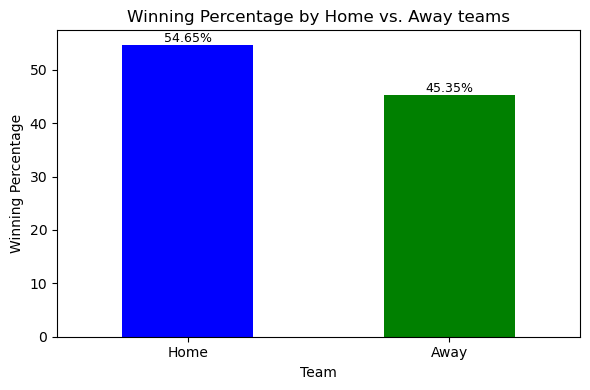

In [1153]:
# Sort the data by winning percentage in descending order
sorted_winning_percentage = winning_percentage.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(6, 4))
sorted_winning_percentage.plot(kind='bar', color=['blue', 'green'])

# Set the x-axis labels and the bar values
plt.xticks([0, 1], ['Home', 'Away'], rotation=0)
for i, v in enumerate(sorted_winning_percentage):
    plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontsize=9)

# Customize the plot
plt.title('Winning Percentage by Home vs. Away teams')
plt.xlabel('Team')
plt.ylabel('Winning Percentage')

# Show the plot
plt.tight_layout()
plt.show()

Now let's take a look at all teams, sorted by number of wins over the seasons included in the dataset.

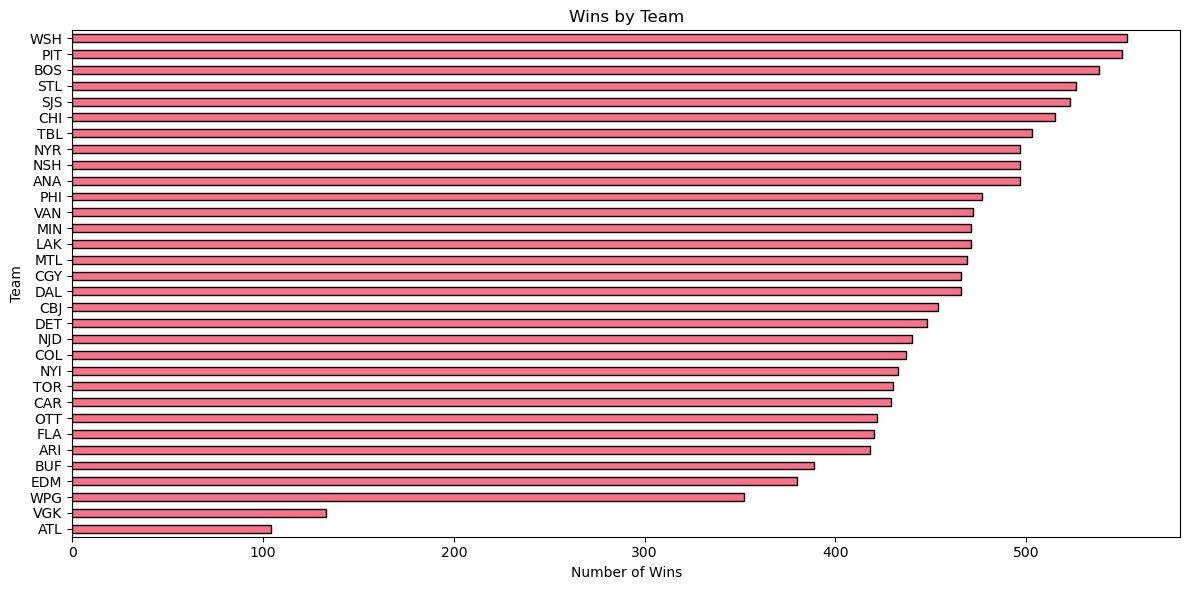

In [1095]:
# Group by 'team' and count the wins
win_counts = merged_df.groupby('team_x')['won'].sum()

# Sort teams by the number of wins in descending order
win_counts = win_counts.sort_values()

# Create a bar chart
plt.figure(figsize=(12, 6))
win_counts.plot(kind='barh', edgecolor='black')

# Set labels and title
plt.xlabel('Number of Wins')
plt.ylabel('Team')
plt.title('Wins by Team')

# Show the plot
plt.tight_layout()
plt.show()

We can see from this that Vegas (VGK) is near the botto in number of wins, which makes sense because they were only in the league for three of those seasons. The list also points out another issue with the dataset, which we have mentioned before. Atlanta (ATL) moved to Winnipeg(WPG), so their wins should be combined. While it shouldn't make any difference to the analysis, I will go ahead an combine them.

In [1096]:
merged_df['team_x'] = merged_df['team_x'].replace({'ATL': 'WPG'})

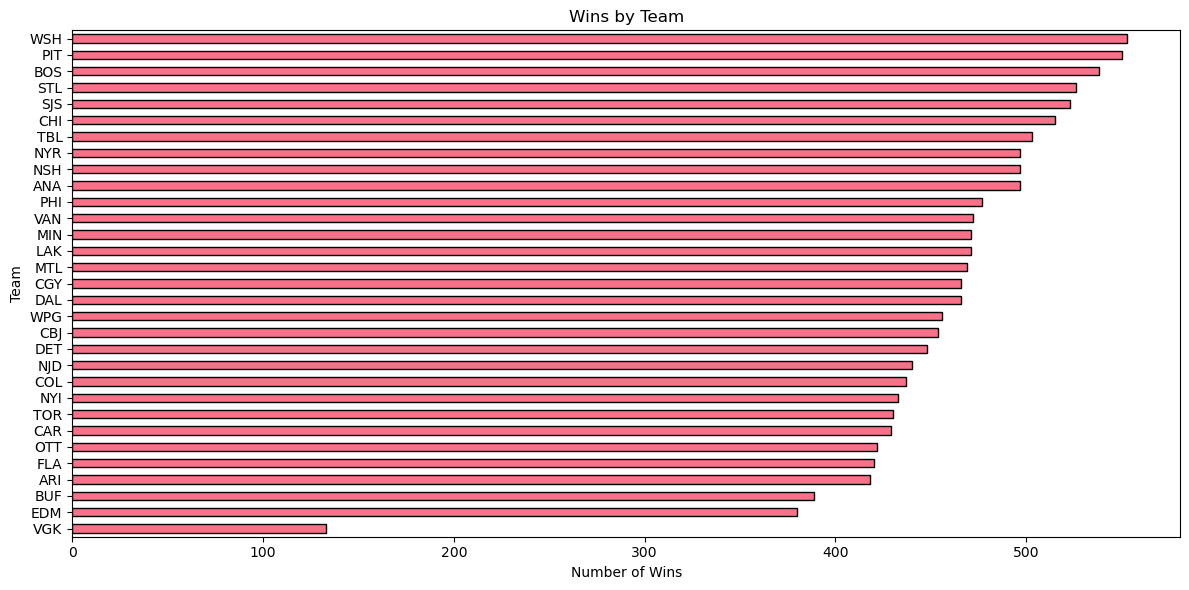

In [1097]:
# Group by 'team' and count the wins
win_counts = merged_df.groupby('team_x')['won'].sum()

# Sort teams by the number of wins in descending order
win_counts = win_counts.sort_values()

# Create a bar chart
plt.figure(figsize=(12, 6))
win_counts.plot(kind='barh', edgecolor='black')

# Set labels and title
plt.xlabel('Number of Wins')
plt.ylabel('Team')
plt.title('Wins by Team')

# Show the plot
plt.tight_layout()
plt.show()

This should make fans in Winnipeg happier. And fans in Edmonton and Buffalo less happy!

Now let's take a look at the distribution of the number of goals scored per team per game.

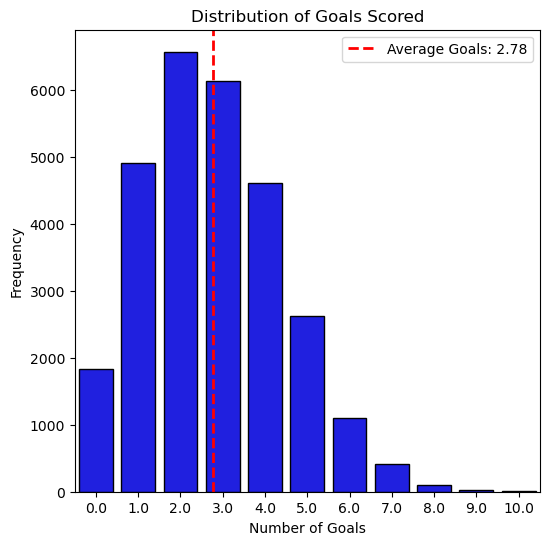

In [1103]:
# Create a countplot of goals scored
plt.figure(figsize=(6, 6))
sns.countplot(data=merged_df, x='goals', color='blue', edgecolor='black')

# Calculate and plot the average number of goals scored
average_goals = merged_df['goals'].mean()
plt.axvline(average_goals, color='red', linestyle='dashed', linewidth=2, label=f'Average Goals: {average_goals:.2f}')

# Label the graph
plt.title('Distribution of Goals Scored')
plt.xlabel('Number of Goals')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()


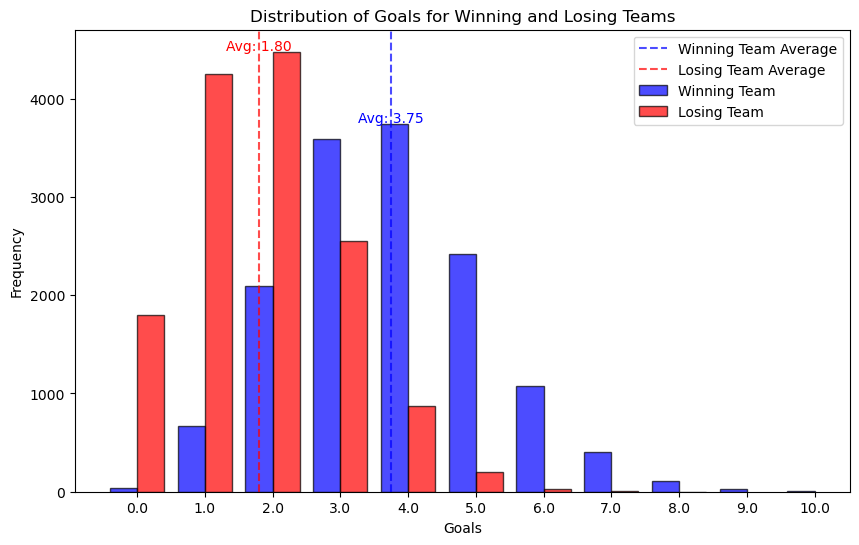

In [1157]:
import matplotlib.pyplot as plt

# Filter the dataframe for winning and losing teams
winning_team_goals = merged_df[merged_df['won'] == 1]['goals']
losing_team_goals = merged_df[merged_df['won'] == 0]['goals']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set the width of the bars
width = 0.4

# Calculate the frequency of unique values for winning and losing teams
winning_team_goal_counts = winning_team_goals.value_counts().sort_index()
losing_team_goal_counts = losing_team_goals.value_counts().sort_index()

# Create bar positions for the unique values
winning_team_x = winning_team_goal_counts.index
losing_team_x = losing_team_goal_counts.index

# Create bar plots for winning and losing teams
ax.bar(winning_team_x - width/2, winning_team_goal_counts, width=width, alpha=0.7, label='Winning Team', color='blue', edgecolor='black')
ax.bar(losing_team_x + width/2, losing_team_goal_counts, width=width, alpha=0.7, label='Losing Team', color='red', edgecolor='black')

# Calculate the average goals for winning and losing teams
winning_team_average = winning_team_goals.mean()
losing_team_average = losing_team_goals.mean()

# Add vertical lines for average goals and label the values
ax.axvline(winning_team_average, color='blue', linestyle='--', label='Winning Team Average', alpha=0.7)
ax.axvline(losing_team_average, color='red', linestyle='--', label='Losing Team Average', alpha=0.7)

ax.text(winning_team_average, max(winning_team_goal_counts) + 10, f'Avg: {winning_team_average:.2f}', color='blue', ha='center')
ax.text(losing_team_average, max(losing_team_goal_counts) + 10, f'Avg: {losing_team_average:.2f}', color='red', ha='center')

# Set labels and title
ax.set_xlabel('Goals')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Goals for Winning and Losing Teams')

# Set x-axis ticks and labels
ax.set_xticks(winning_team_x)
ax.set_xticklabels(winning_team_x)

# Add a legend
ax.legend(loc='upper right')

# Show the plot
plt.show()


So the average goals for the winning team is 3.75, while the average goals for the losing team is 1.80. On average, teams win by almost two goals.

Now let's look for correlations among the variables. We expect to see quite a few highly-correlated variables, as well as multicollinearity, since many of the advanced stats are aggregates of other stats.

In [1121]:
merged_df.corr()

C:\Users\User\AppData\Local\Temp\ipykernel_7024\4191659586.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merged_df.corr()


,season,gameDate,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,...,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,team_id,HoA,won,goals,powerPlayOpportunities,powerPlayGoals
season,1.000000e+00,9.914979e-01,3.477419e-08,-1.193902e-07,-5.025771e-08,0.061166,0.062829,0.053452,0.087171,0.075281,...,0.040040,0.058812,0.059695,0.062118,0.104924,2.354038e-16,-2.270636e-14,0.036403,-0.199539,-0.053150
gameDate,9.914979e-01,1.000000e+00,4.179624e-08,-5.828586e-08,-4.753332e-08,0.061315,0.062220,0.052790,0.087473,0.074885,...,0.038953,0.058436,0.059335,0.061744,0.103609,-1.034235e-15,-1.236174e-14,0.035151,-0.212085,-0.058348
xGoalsPercentage,3.477419e-08,4.179624e-08,1.000000e+00,5.329051e-01,6.269011e-01,0.487929,0.687862,0.509043,0.409889,0.460334,...,-0.406340,-0.622964,-0.615963,-0.613421,-0.008729,2.313368e-01,3.159563e-01,0.285457,0.180802,0.225323
corsiPercentage,-1.193902e-07,-5.828586e-08,5.329051e-01,1.000000e+00,9.292686e-01,0.685723,0.367932,0.652993,0.665059,0.656767,...,-0.187581,-0.398950,-0.360213,-0.357299,0.002796,1.796697e-01,-1.377583e-01,-0.074288,0.206803,-0.006940
fenwickPercentage,-5.025771e-08,-4.753332e-08,6.269011e-01,9.292686e-01,1.000000e+00,0.738984,0.431186,0.702140,0.710235,0.705397,...,-0.224240,-0.456606,-0.424730,-0.423779,-0.002645,1.913292e-01,-4.379707e-02,0.000131,0.203453,0.027945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HoA,2.354038e-16,-1.034235e-15,2.313368e-01,1.796697e-01,1.913292e-01,0.130411,0.143664,0.207160,0.113902,0.145138,...,-0.060480,-0.149505,-0.055768,-0.053152,-0.000096,1.000000e+00,9.294781e-02,0.086534,0.089570,0.063640
won,-2.270636e-14,-1.236174e-14,3.159563e-01,-1.377583e-01,-4.379707e-02,-0.025838,0.217718,-0.015859,-0.056679,-0.033292,...,-0.066324,-0.205024,-0.248261,-0.261229,-0.002753,9.294781e-02,1.000000e+00,0.590753,0.016568,0.231796
goals,3.640321e-02,3.515061e-02,2.854575e-01,-7.428786e-02,1.307301e-04,0.074754,0.363337,0.097078,0.021713,0.062597,...,0.022761,-0.036986,-0.073316,-0.079843,-0.009325,8.653420e-02,5.907533e-01,1.000000,0.095425,0.443409
powerPlayOpportunities,-1.995390e-01,-2.120849e-01,1.808024e-01,2.068025e-01,2.034527e-01,0.169386,0.234016,0.259298,0.106072,0.167946,...,-0.012683,-0.032545,-0.024195,-0.028852,-0.018044,8.957017e-02,1.656764e-02,0.095425,1.000000,0.397517


That's not very practical to read, so we'll try building a heatmap. Not because I believe it will be easier to read, but because I think it will make an interesting design!

C:\Users\User\AppData\Local\Temp\ipykernel_7024\4294397366.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df.corr(),center=0,vmin=-1, vmax=1, cmap='coolwarm')


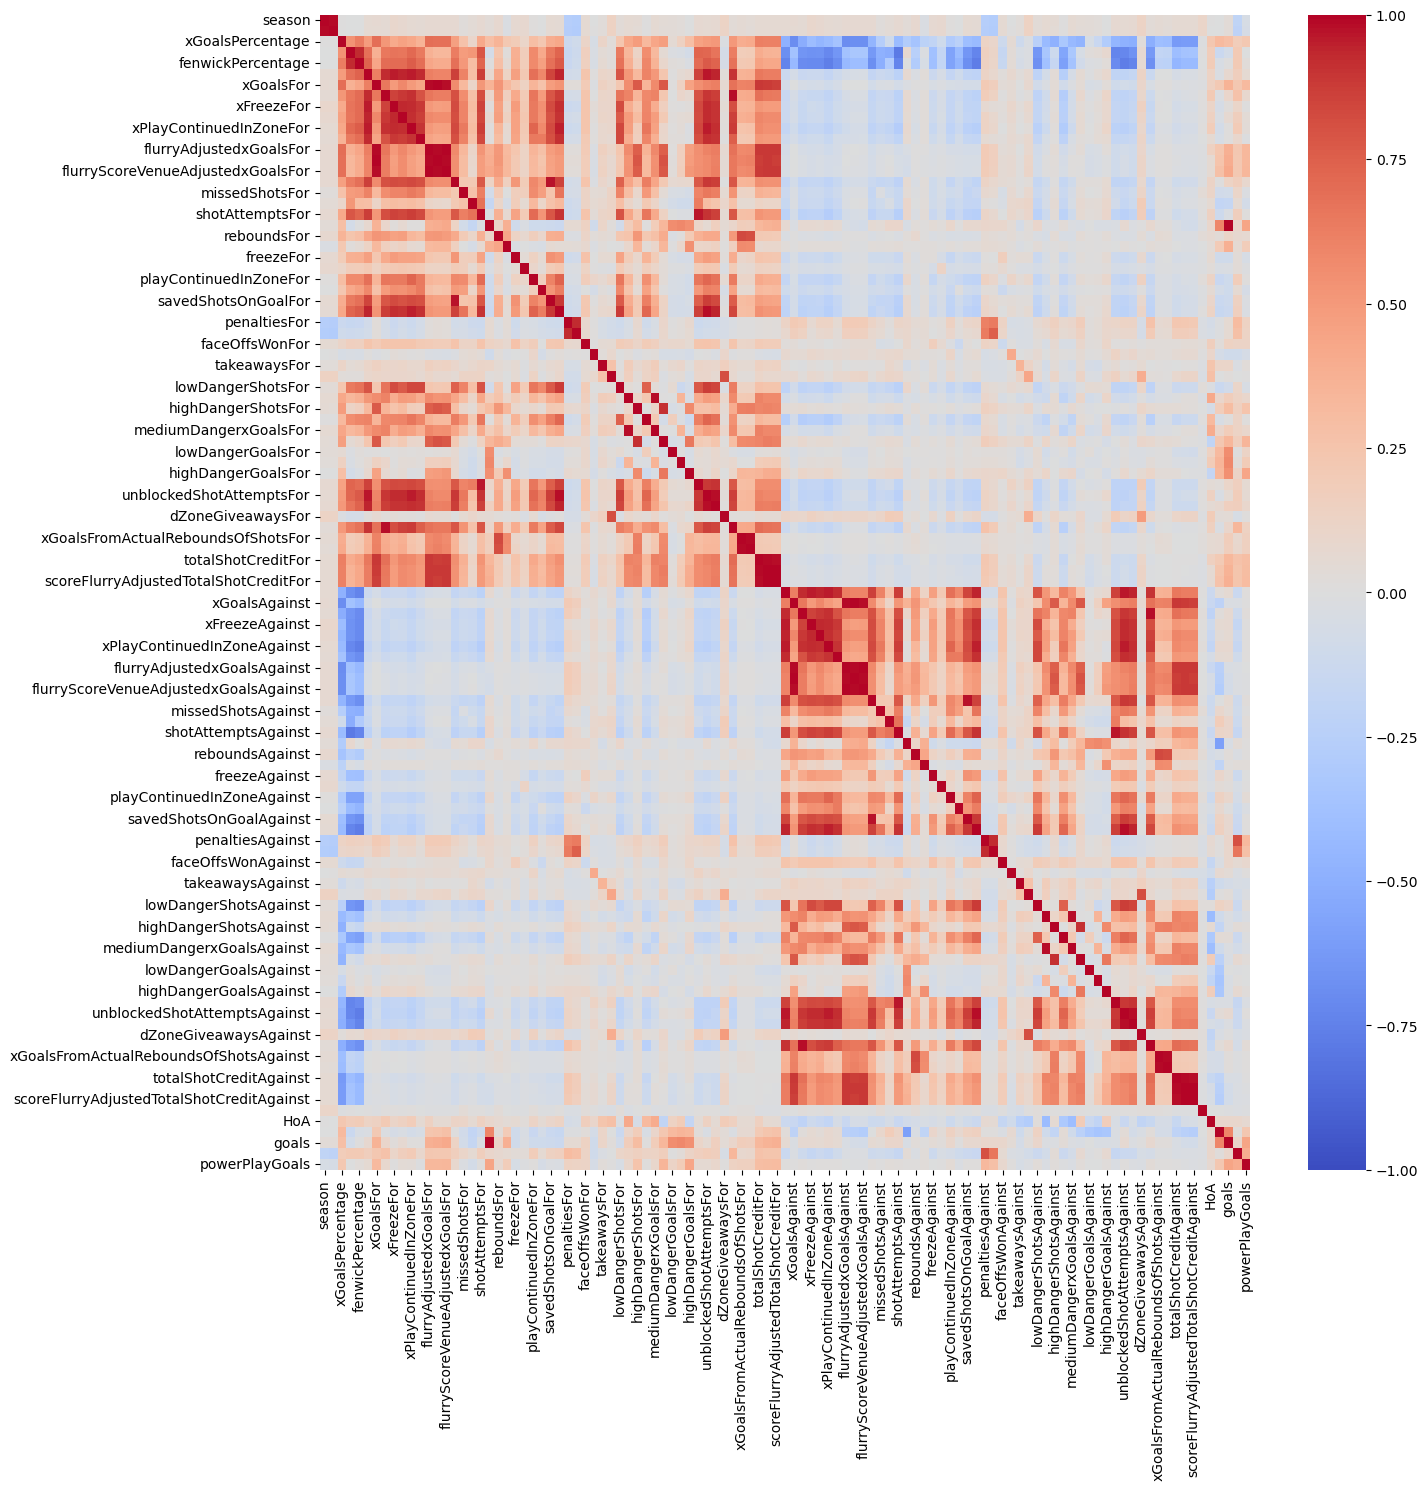

In [1172]:
# Plot the correlation matrix as a heatmap

plt.figure(figsize=(15,15))
sns.heatmap(merged_df.corr(),center=0,vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

There are a lot of strong positive and strong negative correlations in there. One possible next step would be to select a smaller number of variables to investigate. One way to start is to look at the variables with the strongest positive and negative correlations with 'won'.

In [1136]:
merged_df.corr()['won'].sort_values(ascending=False)[1:]

C:\Users\User\AppData\Local\Temp\ipykernel_7024\2971140971.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merged_df.corr()['won'].sort_values(ascending=False)[1:]


goals                                    0.590753
goalsFor                                 0.590706
mediumDangerGoalsFor                     0.346410
highDangerGoalsFor                       0.332693
lowDangerGoalsFor                        0.317003
                                           ...   
flurryScoreVenueAdjustedxGoalsAgainst   -0.275072
lowDangerGoalsAgainst                   -0.317003
highDangerGoalsAgainst                  -0.332693
mediumDangerGoalsAgainst                -0.346410
goalsAgainst                            -0.590706
Name: won, Length: 106, dtype: float64

Let's make bar charts showing the 20 variables with the highest positive and negative correlations.

C:\Users\User\AppData\Local\Temp\ipykernel_7024\3364138883.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = merged_df.corr()['won'].sort_values(ascending=False)[1:]


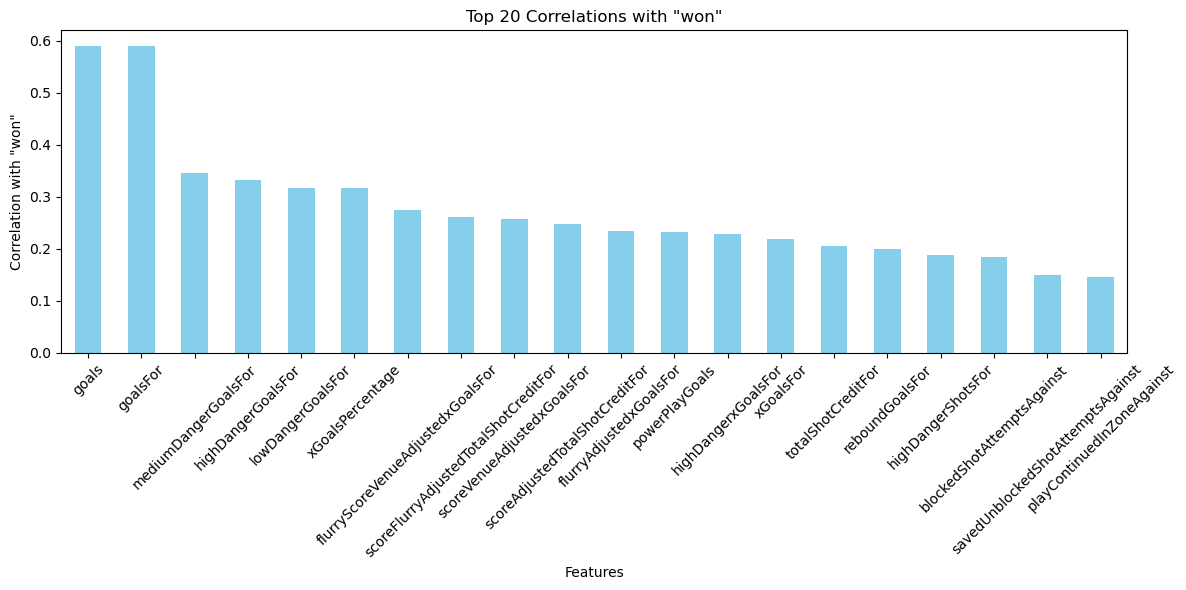

In [1169]:
# Calculate correlations with the 'won' column
correlations = merged_df.corr()['won'].sort_values(ascending=False)[1:]
top_20_correlations = correlations.head(20)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create a bar plot for the top 20 correlations
top_20_correlations.plot(kind='bar', ax=ax, color='skyblue')

# Set labels and title
ax.set_xlabel('Features')
ax.set_ylabel('Correlation with "won"')
ax.set_title('Top 20 Correlations with "won"')

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Some interesting stuff in there. Not surprisingly, goals scored appears to be the biggest driver of wins (note that I will need to investigate the difference between 'goals' and 'goalsFor' - they should be the same). Subsets of goals scored also appear on the list. Perhaps more interestingly, xGoals (Expected Goals) appears frequently on the list. xGoals is an advanced stat calculated based on a formula looking at the scoring chances that teams get in a game. In particular, the xGoalsPercentage, which is a ratio of xGoals to opposing team xGoals is high on the list. These are primarily offensive stats, with defensive stats not being as correlated with wins.

Let's look at the negative correlations.

C:\Users\User\AppData\Local\Temp\ipykernel_7024\3434052709.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  neg_correlations = merged_df.corr()['won'].sort_values(ascending=False)


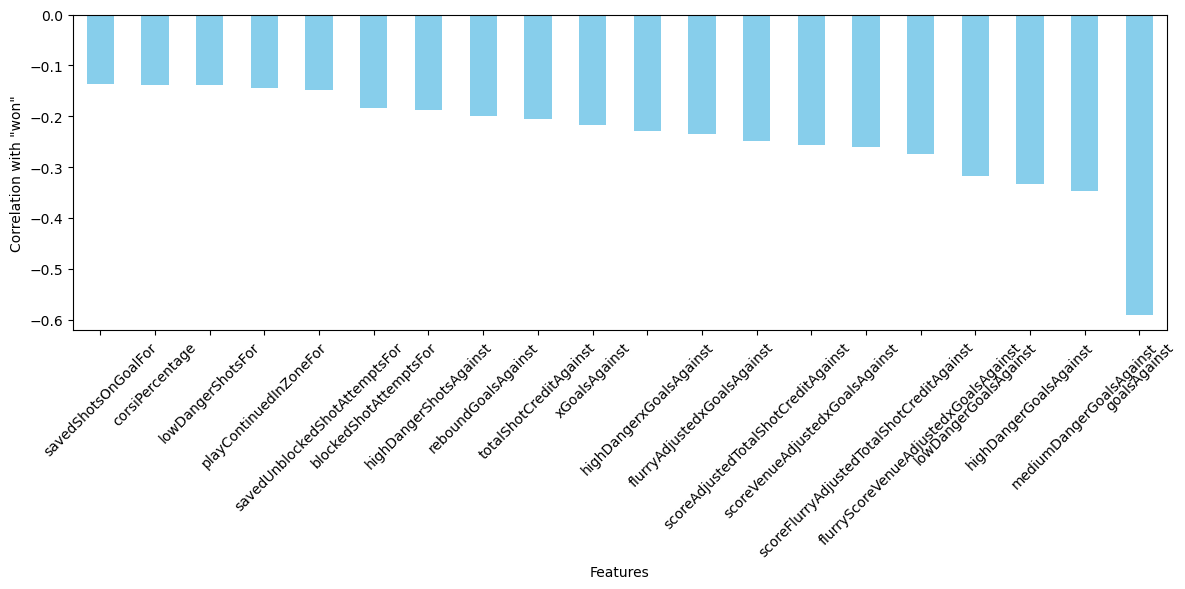

In [1170]:
# Calculate correlations with the 'won' column
neg_correlations = merged_df.corr()['won'].sort_values(ascending=False)
top_20_neg_correlations = neg_correlations.tail(20)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create a bar plot for the top 20 negative correlations
top_20_neg_correlations.plot(kind='bar', ax=ax, color='skyblue')

# Set labels and title
ax.set_xlabel('Features')
ax.set_ylabel('Correlation with "won"')


# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Again not surprisingly, goals against is the highest driver of losses. Many of these are mirror images of the entries in the positive correlation graph, applying the same stats to the opposing team, but there are some differences. For instance, lowDangerShotsFor is an offensive category for the team we are analyzing for their likelihood of winning. It appears that if a team takes a lot of shots, but they are low danger shots, it actually decreases their chances of winning. We also see Corsi on here, which is the most well-known of all the Advanced Stats. The corsi percentage here is the total shots attempted by the team (shots on goal + blocked shots + missed shots) as a percentage of total shots attempted by both teams. As the percentage decreases, the team is less likely to win.

While I'm here, I am going to export my new dataset to a CSV file.

In [1141]:
# Specify file path and name
file_path = "merged_dataset.csv"

# Use to_csv to export
merged_df.to_csv(file_path, index=False)

## **Issues and Next Steps**

There remain some data quality issues that I hope to address:

- The lack of data for 2020 through 2023 represents a gap that may be relevant for ongoing predictions, particularly if there have been trends over time that have continued in the past three years. Given that there are only a handful of variables that are missing from the more complete dataset, I should be able to source that, even if it involves some manual work.
- I mentioned above that the two datasets have different values for 'goals for'. I haven't dropped one of those columns yet, but I may.
- Some data that I want for a team is only available in the data for the other team in the same game. For example, penalty kill percentage is the ratio of penalties taken to unsuccessful powerplays for the other team. This is the inverse of the powerplay percentage for the other team, but is only available in one of the two rows for a game. I may need to calculate it based on a separate row in the dataset and include it in the row for each team/game combination.

There is also some additional information that I believe could have relevance on game outcomes that is not included in this dataset, e.g.,:

- I have established that the home team wins ~55% of games, but does that vary based on length of road trip (number of games) or distance traveled? I could potentially calculate the distance between cities where teams play and include that distance as a variable. Similarly, I could count the number of consecutive away games to see if there is any change in expected outcome depending on number of away games played in a row.
- It is widely believed that when a team has to play games on back-to-back days, their chance of winning is decreased for the second game. I could calculate the number of days since the last game and analyze whether this is truly a factor.
- While I have chosen to focus on team stats rather than individual player stats, there is one area where I would consider an exception: goaltenders. The quality of goaltender is likely to have a very high impact on the outcome of the game, in particular whether the team played their starter or their backup. If possible, I will consider adding goaltender stats to the analysis.
- While I do not want to aggregate individual player statistics, it may be possible to include some kind of team strength factor based on salary cap hit. Each team is limited in how much they can spend on player salaries, with the upper bound being the salary cap, but they do not need to spend to the cap. It may be that teams that spend more have better players, and therefore an advantage. In addition, if I can get salary cap data on a game-by-game basis (a big 'if'), it could help account for situations where a team's start player or players is injured and cannot play, as the salary total for that game would be lower than if the highly-paid player was playing.
- There are some cases where I would most likely want to calculate a derived value rather than using the values that are in the dataset. For example, I have data on powerplay opportunities and powerplay goals, but I would like those consolidated into a single powerplay percentage value. The same holds for saves vs. goals against, i.e., save percentage. There may be other similar metrics that I want to derive, so I will need to plan for that.
- While much of this data will be helpful in identifying key drivers of game outcomes, how well that can be used to predict future outcomes is unclear. Forecasting single-game performance based on an average of 10+ years of data seems optimistic. It may make sense to build time series data of the last n games to see if there are short-term trends that help predict outcomes.